# TCGA PANCAN Multi-Omics Data Loading and Cox Regression Feature Engineering

This notebook implements comprehensive loading and preprocessing of TCGA PANCAN multi-omics data with Cox regression analysis for feature engineering.

## Data Files Structure:
1. **Transcriptome**: `unc.edu_PANCAN_IlluminaHiSeq_RNASeqV2.geneExp_whitelisted.tsv`
2. **Copy Number Variation**: `CNV.GISTIC_call.all_data_by_genes_whitelisted.tsv`
3. **microRNA**: `bcgsc.ca_PANCAN_IlluminaHiSeq_miRNASeq.miRNAExp_whitelisted.tsv`
4. **RPPA**: `mdanderson.org_PANCAN_MDA_RPPA_Core.RPPA_whitelisted.tsv`
5. **Mutations**: `tcga_pancancer_082115.vep.filter_whitelisted.maf.gz`
6. **Clinical**: `clinical_PANCAN_patient_with_followup.tsv`

## Output:
- Cox coefficient lookup tables
- Processed multi-omics data (patient × features)
- Feature importance rankings
- Data quality reports

## 1. Environment Setup and Library Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import gzip
from tqdm import tqdm
import pickle
import warnings
import json
import os
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
from collections import defaultdict

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

# Define paths
DATA_RAW_PATH = Path('../data/raw')
DATA_PROCESSED_PATH = Path('../data/processed')
RESULTS_PATH = Path('../results')

# Create directories if they don't exist
DATA_PROCESSED_PATH.mkdir(exist_ok=True)
RESULTS_PATH.mkdir(exist_ok=True)

print("Environment setup complete!")
print(f"Raw data path: {DATA_RAW_PATH}")
print(f"Processed data path: {DATA_PROCESSED_PATH}")
print(f"Results path: {RESULTS_PATH}")

Environment setup complete!
Raw data path: ../data/raw
Processed data path: ../data/processed
Results path: ../results


## 2. Data Loading Functions

In [10]:
def standardize_patient_id(patient_id):
    """Standardize TCGA patient IDs to 12-character format (TCGA-XX-XXXX)"""
    if isinstance(patient_id, str):
        # Remove any trailing parts after the sample type (e.g., -01A, -11A)
        parts = patient_id.split('-')
        if len(parts) >= 3:
            return f"{parts[0]}-{parts[1]}-{parts[2]}"
    return patient_id

def load_transcriptome_data(file_path):
    """Load and preprocess transcriptome data with log2 transformation"""
    print("Loading transcriptome data...")
    
    # Load data
    df = pd.read_csv(file_path, sep='\t', index_col=0)
    
    # Parse gene symbols from first column (Gene_Symbol|Entrez_ID)
    gene_info = df.index.str.split('|', expand=True)
    
    # Convert to DataFrame to handle properly
    if hasattr(gene_info, 'to_frame'):
        gene_info_df = gene_info.to_frame()
    else:
        gene_info_df = pd.DataFrame(gene_info.tolist(), columns=['gene_symbol', 'entrez_id'])
    
    # Handle case where gene symbols might be missing (marked as "?")
    if gene_info_df.shape[1] >= 2:
        gene_symbols = gene_info_df.iloc[:, 0]
        entrez_ids = gene_info_df.iloc[:, 1]
        
        # If gene symbols are "?", use Entrez IDs instead
        gene_symbols = gene_symbols.where(gene_symbols != '?', 'Gene_' + entrez_ids.astype(str))
    else:
        # No "|" separator found, use original index
        gene_symbols = df.index
        entrez_ids = None
    
    # Set gene symbols as index
    df.index = gene_symbols
    
    # Transpose to get patients as rows
    df = df.T
    
    # Standardize patient IDs
    df.index = [standardize_patient_id(pid) for pid in df.index]
    
    # Store original values for comparison
    original_stats = {
        'mean': df.values.mean(),
        'std': df.values.std(),
        'min': df.values.min(),
        'max': df.values.max(),
        'zeros': (df.values == 0).sum()
    }
    
    # Apply log2 transformation: log2(x + 1)
    df_log = np.log2(df + 1)
    
    # Store transformed stats
    transformed_stats = {
        'mean': df_log.values.mean(),
        'std': df_log.values.std(),
        'min': df_log.values.min(),
        'max': df_log.values.max(),
        'zeros': (df_log.values == 0).sum()
    }
    
    transformation_stats = {
        'original': original_stats,
        'transformed': transformed_stats,
        'n_patients': df_log.shape[0],
        'n_genes': df_log.shape[1]
    }
    
    print(f"Transcriptome data loaded: {df_log.shape[0]} patients × {df_log.shape[1]} genes")
    
    return df_log, transformation_stats

def load_cnv_data(file_path):
    """Load and preprocess CNV data"""
    print("Loading CNV data...")
    
    # Load data
    df = pd.read_csv(file_path, sep='\t')
    
    # Skip first 3 annotation columns and set gene symbol as index
    gene_symbols = df.iloc[:, 0]  # First column is Gene Symbol
    df_values = df.iloc[:, 3:]  # Skip first 3 columns (Gene Symbol, Locus ID, Cytoband)
    df_values.index = gene_symbols
    
    # Transpose to get patients as rows
    df_values = df_values.T
    
    # Standardize patient IDs
    df_values.index = [standardize_patient_id(pid) for pid in df_values.index]
    
    print(f"CNV data loaded: {df_values.shape[0]} patients × {df_values.shape[1]} genes")
    
    return df_values

def load_mirna_data(file_path):
    """Load and preprocess microRNA data"""
    print("Loading microRNA data...")
    
    # Load data
    df = pd.read_csv(file_path, sep='\t', index_col=0)
    
    # Transpose to get patients as rows
    df = df.T
    
    # Standardize patient IDs
    df.index = [standardize_patient_id(pid) for pid in df.index]
    
    print(f"microRNA data loaded: {df.shape[0]} patients × {df.shape[1]} miRNAs")
    
    return df

def load_rppa_data(file_path):
    """Load and preprocess RPPA protein data"""
    print("Loading RPPA data...")
    
    # Load data
    df = pd.read_csv(file_path, sep='\t', index_col=0)
    
    # Transpose to get patients as rows
    df = df.T
    
    # Standardize patient IDs
    df.index = [standardize_patient_id(pid) for pid in df.index]
    
    print(f"RPPA data loaded: {df.shape[0]} patients × {df.shape[1]} proteins")
    
    return df

def load_mutation_data(file_path):
    """Load and preprocess mutation data from MAF format"""
    print("Loading mutation data...")
    
    # Load MAF file with encoding handling, skipping the version line
    try:
        with gzip.open(file_path, 'rt', encoding='utf-8') as f:
            # Skip the first line (#version 2.4)
            first_line = f.readline()
            if first_line.startswith('#version'):
                # Read the rest of the file
                df = pd.read_csv(f, sep='\t', low_memory=False)
            else:
                # Reset file pointer and read normally
                f.seek(0)
                df = pd.read_csv(f, sep='\t', low_memory=False)
    except UnicodeDecodeError:
        with gzip.open(file_path, 'rt', encoding='latin-1') as f:
            first_line = f.readline()
            if first_line.startswith('#version'):
                df = pd.read_csv(f, sep='\t', low_memory=False)
            else:
                f.seek(0)
                df = pd.read_csv(f, sep='\t', low_memory=False)
    
    print(f"Raw MAF data: {df.shape[0]} mutations")
    
    # Define mutation impact scoring
    variant_impact = {
        'Silent': 0,
        'Missense_Mutation': 1,
        'Nonsense_Mutation': 2,
        'Frame_Shift_Del': 2,
        'Frame_Shift_Ins': 2,
        'Splice_Site': 2,
        'Translation_Start_Site': 1,
        'Nonstop_Mutation': 1,
        'In_Frame_Del': 1,
        'In_Frame_Ins': 1,
        "3'UTR": 0,
        "5'UTR": 0,
        'Intron': 0,
        'RNA': 0
    }
    
    # Filter for relevant columns
    required_cols = ['Hugo_Symbol', 'Tumor_Sample_Barcode', 'Variant_Classification']
    if not all(col in df.columns for col in required_cols):
        print(f"Missing required columns. Available columns: {list(df.columns[:10])}...")
        return pd.DataFrame()
    
    # Standardize patient IDs
    df['Patient_ID'] = df['Tumor_Sample_Barcode'].apply(standardize_patient_id)
    
    # Map variant classifications to impact scores
    df['Impact_Score'] = df['Variant_Classification'].map(variant_impact).fillna(0)
    
    # Aggregate mutations per patient-gene pair (take maximum impact)
    mutation_matrix = df.groupby(['Patient_ID', 'Hugo_Symbol'])['Impact_Score'].max().unstack(fill_value=0)
    
    print(f"Mutation matrix: {mutation_matrix.shape[0]} patients × {mutation_matrix.shape[1]} genes")
    
    return mutation_matrix

def load_clinical_data(file_path):
    """Load and preprocess clinical data"""
    print("Loading clinical data...")
    
    # Try different encodings to handle problematic characters
    encodings_to_try = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
    
    df = None
    for encoding in encodings_to_try:
        try:
            df = pd.read_csv(file_path, sep='\t', encoding=encoding, low_memory=False)
            print(f"Successfully loaded clinical data with {encoding} encoding")
            break
        except UnicodeDecodeError:
            continue
    
    if df is None:
        # Last resort: ignore problematic characters
        df = pd.read_csv(file_path, sep='\t', encoding='utf-8', errors='ignore', low_memory=False)
        print("Loaded clinical data with UTF-8 encoding, ignoring problematic characters")
    
    # Standardize patient IDs
    df['bcr_patient_barcode'] = df['bcr_patient_barcode'].apply(standardize_patient_id)
    
    # Set patient ID as index
    df = df.set_index('bcr_patient_barcode')
    
    # Extract survival information
    survival_cols = ['vital_status', 'days_to_death', 'days_to_last_followup', 'acronym']
    available_cols = [col for col in survival_cols if col in df.columns]
    
    if 'vital_status' in df.columns:
        # Create survival time and event columns
        df['survival_time'] = np.where(
            df['vital_status'] == 'Dead',
            df['days_to_death'] if 'days_to_death' in df.columns else np.nan,
            df['days_to_last_followup'] if 'days_to_last_followup' in df.columns else np.nan
        )
        df['survival_event'] = (df['vital_status'] == 'Dead').astype(int)
    
    print(f"Clinical data loaded: {df.shape[0]} patients × {df.shape[1]} features")
    
    return df

## 3. Load All Data

In [8]:
# Load all datasets
print("=" * 60)
print("LOADING TCGA PANCAN MULTI-OMICS DATA")
print("=" * 60)

# Load transcriptome data
expression_data, transformation_stats = load_transcriptome_data(
    DATA_RAW_PATH / 'unc.edu_PANCAN_IlluminaHiSeq_RNASeqV2.geneExp_whitelisted.tsv'
)

# Load CNV data
cnv_data = load_cnv_data(
    DATA_RAW_PATH / 'CNV.GISTIC_call.all_data_by_genes_whitelisted.tsv'
)

# Load microRNA data
mirna_data = load_mirna_data(
    DATA_RAW_PATH / 'bcgsc.ca_PANCAN_IlluminaHiSeq_miRNASeq.miRNAExp_whitelisted.tsv'
)

# Load RPPA data
rppa_data = load_rppa_data(
    DATA_RAW_PATH / 'mdanderson.org_PANCAN_MDA_RPPA_Core.RPPA_whitelisted.tsv'
)

# Load mutation data
mutation_data = load_mutation_data(
    DATA_RAW_PATH / 'tcga_pancancer_082115.vep.filter_whitelisted.maf.gz'
)

# Load clinical data
clinical_data = load_clinical_data(
    DATA_RAW_PATH / 'clinical_PANCAN_patient_with_followup.tsv'
)

print("\n" + "=" * 60)
print("DATA LOADING SUMMARY")
print("=" * 60)
print(f"Expression: {expression_data.shape[0]} patients × {expression_data.shape[1]} genes")
print(f"CNV: {cnv_data.shape[0]} patients × {cnv_data.shape[1]} genes")
print(f"microRNA: {mirna_data.shape[0]} patients × {mirna_data.shape[1]} miRNAs")
print(f"RPPA: {rppa_data.shape[0]} patients × {rppa_data.shape[1]} proteins")
print(f"Mutations: {mutation_data.shape[0]} patients × {mutation_data.shape[1]} genes")
print(f"Clinical: {clinical_data.shape[0]} patients × {clinical_data.shape[1]} features")

LOADING TCGA PANCAN MULTI-OMICS DATA
Loading transcriptome data...
Transcriptome data loaded: 10327 patients × 20531 genes
Loading CNV data...
Transcriptome data loaded: 10327 patients × 20531 genes
Loading CNV data...
CNV data loaded: 10713 patients × 25128 genes
Loading microRNA data...
CNV data loaded: 10713 patients × 25128 genes
Loading microRNA data...
microRNA data loaded: 9350 patients × 1071 miRNAs
Loading RPPA data...
microRNA data loaded: 9350 patients × 1071 miRNAs
Loading RPPA data...
RPPA data loaded: 7656 patients × 387 proteins
Loading mutation data...
RPPA data loaded: 7656 patients × 387 proteins
Loading mutation data...
Raw MAF data: 1781555 mutations
Raw MAF data: 1781555 mutations
Mutation matrix: 8670 patients × 25483 genes
Loading clinical data...
Mutation matrix: 8670 patients × 25483 genes
Loading clinical data...
Successfully loaded clinical data with latin-1 encoding
Clinical data loaded: 10956 patients × 747 features

DATA LOADING SUMMARY
Expression: 10327 p

## 4. Patient ID Matching and Data Integration

Patient counts per dataset:
Expression: 9591 patients
CNV: 10713 patients
microRNA: 8677 patients
RPPA: 7561 patients
Mutations: 8670 patients
Clinical: 10956 patients

Common patients across all datasets: 4755
Common patients with survival data: 4755


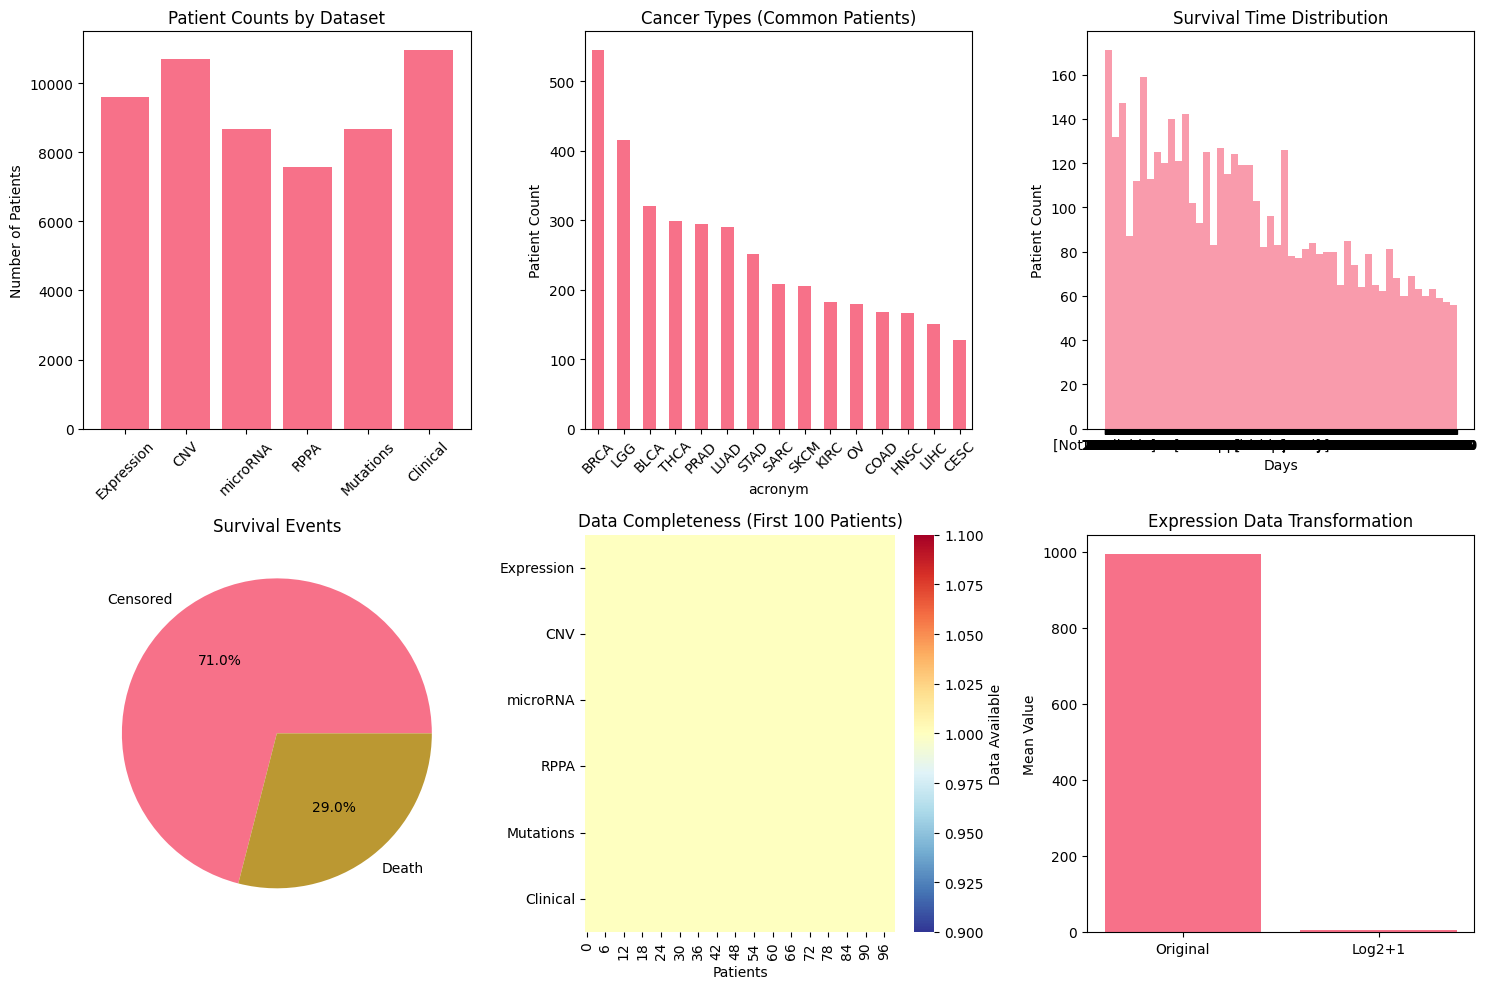


Using 4755 patients with complete omics and survival data

Expression Data Transformation Statistics:
Original data - Mean: 995.119, Std: 7962.535
Transformed data - Mean: 6.405, Std: 4.076
Zero values - Original: 31002642, Transformed: 31002642


In [15]:
# Analyze patient overlap across datasets
datasets = {
    'Expression': set(expression_data.index),
    'CNV': set(cnv_data.index),
    'microRNA': set(mirna_data.index),
    'RPPA': set(rppa_data.index),
    'Mutations': set(mutation_data.index),
    'Clinical': set(clinical_data.index)
}

print("Patient counts per dataset:")
for name, patients in datasets.items():
    print(f"{name}: {len(patients)} patients")

# Find common patients across all datasets
common_patients = set.intersection(*datasets.values())
print(f"\nCommon patients across all datasets: {len(common_patients)}")

# Find common patients with survival data
survival_patients = clinical_data.dropna(subset=['survival_time', 'survival_event']).index
common_survival_patients = common_patients.intersection(set(survival_patients))
print(f"Common patients with survival data: {len(common_survival_patients)}")

# Convert to list for pandas indexing
common_survival_patients_list = sorted(list(common_survival_patients))

# Create overlap visualization
plt.figure(figsize=(15, 10))

# Plot patient counts
plt.subplot(2, 3, 1)
dataset_counts = [len(patients) for patients in datasets.values()]
plt.bar(range(len(datasets)), dataset_counts)
plt.xticks(range(len(datasets)), list(datasets.keys()), rotation=45)
plt.title('Patient Counts by Dataset')
plt.ylabel('Number of Patients')

# Plot cancer type distribution
if 'acronym' in clinical_data.columns:
    cancer_counts = clinical_data.loc[common_survival_patients_list, 'acronym'].value_counts()
    plt.subplot(2, 3, 2)
    cancer_counts.head(15).plot(kind='bar')
    plt.title('Cancer Types (Common Patients)')
    plt.xticks(rotation=45)
    plt.ylabel('Patient Count')

# Plot survival data quality
if 'survival_time' in clinical_data.columns:
    plt.subplot(2, 3, 3)
    survival_times = clinical_data.loc[common_survival_patients_list, 'survival_time']
    plt.hist(survival_times.dropna(), bins=50, alpha=0.7)
    plt.title('Survival Time Distribution')
    plt.xlabel('Days')
    plt.ylabel('Patient Count')

# Plot survival events
if 'survival_event' in clinical_data.columns:
    plt.subplot(2, 3, 4)
    event_counts = clinical_data.loc[common_survival_patients_list, 'survival_event'].value_counts()
    plt.pie(event_counts.values, labels=['Censored', 'Death'], autopct='%1.1f%%')
    plt.title('Survival Events')

# Plot data completeness heatmap
plt.subplot(2, 3, 5)
completeness_data = []
for patient in sorted(list(common_patients))[:100]:  # Show first 100 patients
    row = [1 if patient in datasets[name] else 0 for name in datasets.keys()]
    completeness_data.append(row)

completeness_df = pd.DataFrame(completeness_data, columns=list(datasets.keys()))
sns.heatmap(completeness_df.T, cmap='RdYlBu_r', cbar_kws={'label': 'Data Available'})
plt.title('Data Completeness (First 100 Patients)')
plt.xlabel('Patients')

# Plot transformation stats for expression data
plt.subplot(2, 3, 6)
original_mean = transformation_stats['original']['mean']
transformed_mean = transformation_stats['transformed']['mean']
plt.bar(['Original', 'Log2+1'], [original_mean, transformed_mean])
plt.title('Expression Data Transformation')
plt.ylabel('Mean Value')

plt.tight_layout()
plt.show()

# Store common patients for further analysis
print(f"\nUsing {len(common_survival_patients_list)} patients with complete omics and survival data")
final_patient_list = common_survival_patients_list

# Display transformation statistics
print(f"\nExpression Data Transformation Statistics:")
print(f"Original data - Mean: {transformation_stats['original']['mean']:.3f}, Std: {transformation_stats['original']['std']:.3f}")
print(f"Transformed data - Mean: {transformation_stats['transformed']['mean']:.3f}, Std: {transformation_stats['transformed']['std']:.3f}")
print(f"Zero values - Original: {transformation_stats['original']['zeros']}, Transformed: {transformation_stats['transformed']['zeros']}")

## 5. Cox Regression Analysis Functions

In [ ]:
def perform_cox_regression_by_cancer(omics_data, clinical_data, omics_type, min_patients=20, p_threshold=0.05):
    """
    Perform Cox regression analysis by cancer type for given omics data
    
    Parameters:
    - omics_data: DataFrame with patients as rows, features as columns
    - clinical_data: DataFrame with survival information
    - omics_type: String identifier for the omics type
    - min_patients: Minimum number of patients required per cancer type
    - p_threshold: P-value threshold for significance
    
    Returns:
    - cox_results: Dictionary with results by cancer type
    - summary_stats: Overall summary statistics
    """
    
    print(f"\nPerforming Cox regression analysis for {omics_type} data...")
    
    # Filter for common patients
    common_patients = list(set(omics_data.index).intersection(set(clinical_data.index)))
    
    # Get survival data for common patients
    survival_data = clinical_data.loc[common_patients, ['survival_time', 'survival_event', 'acronym']].copy()
    survival_data = survival_data.dropna()
    
    # Filter omics data for patients with survival data
    omics_filtered = omics_data.loc[survival_data.index].copy()
    
    print(f"Analysis dataset: {len(survival_data)} patients with {omics_filtered.shape[1]} features")
    
    # Group by cancer type
    cancer_types = survival_data['acronym'].value_counts()
    valid_cancers = cancer_types[cancer_types >= min_patients].index
    
    print(f"Cancer types with >= {min_patients} patients: {len(valid_cancers)}")
    
    cox_results = {}
    summary_stats = {
        'total_features': omics_filtered.shape[1],
        'total_patients': len(survival_data),
        'cancer_types': len(valid_cancers),
        'significant_features': {},
        'top_features': {}
    }
    
    for cancer in tqdm(valid_cancers, desc=f"Processing {omics_type}"):
        # Get patients for this cancer type
        cancer_patients = survival_data[survival_data['acronym'] == cancer].index
        
        # Get omics and survival data for this cancer
        cancer_omics = omics_filtered.loc[cancer_patients]
        cancer_survival = survival_data.loc[cancer_patients, ['survival_time', 'survival_event']]
        
        # Remove features with zero variance
        feature_vars = cancer_omics.var()
        valid_features = feature_vars[feature_vars > 0].index
        cancer_omics_filtered = cancer_omics[valid_features]
        
        print(f"\n{cancer}: {len(cancer_patients)} patients, {len(valid_features)} variable features")
        
        # Perform univariate Cox regression for each feature
        feature_results = []
        
        for feature in valid_features:
            try:
                # Create dataframe for Cox regression
                cox_data = pd.DataFrame({
                    'T': cancer_survival['survival_time'],
                    'E': cancer_survival['survival_event'],
                    feature: cancer_omics_filtered[feature]
                })
                
                # Remove rows with missing data
                cox_data = cox_data.dropna()
                
                if len(cox_data) < 5:  # Need at least 5 observations
                    continue
                
                # Fit Cox model
                cph = CoxPHFitter()
                cph.fit(cox_data, duration_col='T', event_col='E')
                
                # Extract results
                coef = cph.summary.loc[feature, 'coef']
                p_value = cph.summary.loc[feature, 'p']
                hr = np.exp(coef)
                ci_lower = np.exp(cph.summary.loc[feature, 'coef lower 95%'])
                ci_upper = np.exp(cph.summary.loc[feature, 'coef upper 95%'])
                
                feature_results.append({
                    'feature': feature,
                    'coef': coef,
                    'hr': hr,
                    'p_value': p_value,
                    'ci_lower': ci_lower,
                    'ci_upper': ci_upper,
                    'n_patients': len(cox_data)
                })
                
            except Exception as e:
                # Skip problematic features
                continue
        
        # Convert to DataFrame and sort by p-value
        if feature_results:
            results_df = pd.DataFrame(feature_results)
            results_df = results_df.sort_values('p_value')
            
            # Count significant features
            significant_count = sum(results_df['p_value'] < p_threshold)
            
            cox_results[cancer] = results_df
            summary_stats['significant_features'][cancer] = significant_count
            summary_stats['top_features'][cancer] = results_df.head(10)
            
            print(f"  Significant features (p < {p_threshold}): {significant_count}/{len(results_df)}")
        else:
            print(f"  No valid results for {cancer}")
    
    return cox_results, summary_stats

def create_cox_coefficient_lookup(cox_results_dict, omics_types):
    """Create a comprehensive Cox coefficient lookup table"""
    
    print("\nCreating Cox coefficient lookup tables...")
    
    # Initialize lookup dictionary
    lookup_tables = {}
    
    for omics_type in omics_types:
        if omics_type in cox_results_dict:
            print(f"\nProcessing {omics_type} results...")
            
            # Combine all cancer type results
            all_results = []
            
            for cancer, results_df in cox_results_dict[omics_type].items():
                if not results_df.empty:
                    results_copy = results_df.copy()
                    results_copy['cancer_type'] = cancer
                    results_copy['omics_type'] = omics_type
                    all_results.append(results_copy)
            
            if all_results:
                combined_df = pd.concat(all_results, ignore_index=True)
                
                # Create pivot table: features × cancer_types with coefficients
                pivot_coef = combined_df.pivot_table(
                    index='feature', 
                    columns='cancer_type', 
                    values='coef', 
                    fill_value=0
                )
                
                # Create pivot table for p-values
                pivot_pval = combined_df.pivot_table(
                    index='feature', 
                    columns='cancer_type', 
                    values='p_value', 
                    fill_value=1
                )
                
                # Create summary statistics per feature
                feature_stats = combined_df.groupby('feature').agg({
                    'coef': ['mean', 'std', 'count'],
                    'p_value': ['min', 'mean'],
                    'hr': ['mean']
                }).round(4)
                
                # Flatten column names
                feature_stats.columns = ['_'.join(col).strip() for col in feature_stats.columns]
                
                lookup_tables[omics_type] = {
                    'coefficients': pivot_coef,
                    'p_values': pivot_pval,
                    'feature_stats': feature_stats,
                    'raw_results': combined_df
                }
                
                print(f"  {omics_type}: {len(pivot_coef)} features across {len(pivot_coef.columns)} cancer types")
    
    return lookup_tables

def visualize_cox_results(cox_results, omics_type, top_n=20):
    """Visualize Cox regression results"""
    
    # Combine results across cancer types
    all_results = []
    for cancer, results_df in cox_results.items():
        if not results_df.empty:
            results_copy = results_df.copy()
            results_copy['cancer_type'] = cancer
            all_results.append(results_copy)
    
    if not all_results:
        print(f"No results to visualize for {omics_type}")
        return
    
    combined_df = pd.concat(all_results, ignore_index=True)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Cox Regression Results: {omics_type}', fontsize=16)
    
    # 1. P-value distribution
    axes[0, 0].hist(combined_df['p_value'], bins=50, alpha=0.7)
    axes[0, 0].axvline(x=0.05, color='red', linestyle='--', label='p=0.05')
    axes[0, 0].set_xlabel('P-value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('P-value Distribution')
    axes[0, 0].legend()
    
    # 2. Coefficient distribution
    axes[0, 1].hist(combined_df['coef'], bins=50, alpha=0.7)
    axes[0, 1].axvline(x=0, color='red', linestyle='--', label='coef=0')
    axes[0, 1].set_xlabel('Cox Coefficient')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Coefficient Distribution')
    axes[0, 1].legend()
    
    # 3. Top significant features
    significant_features = combined_df[combined_df['p_value'] < 0.05]
    if len(significant_features) > 0:
        top_features = significant_features.nsmallest(top_n, 'p_value')
        
        # Create a color map for cancer types
        cancer_types = top_features['cancer_type'].unique()
        colors = plt.cm.Set3(np.linspace(0, 1, len(cancer_types)))
        color_map = dict(zip(cancer_types, colors))
        
        scatter_colors = [color_map[cancer] for cancer in top_features['cancer_type']]
        
        scatter = axes[1, 0].scatter(top_features['coef'], -np.log10(top_features['p_value']), 
                                   c=scatter_colors, alpha=0.7)
        axes[1, 0].axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
        axes[1, 0].axvline(x=0, color='red', linestyle='--')
        axes[1, 0].set_xlabel('Cox Coefficient')
        axes[1, 0].set_ylabel('-log10(p-value)')
        axes[1, 0].set_title(f'Top {top_n} Significant Features')
        
        # Add legend for cancer types
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=color_map[cancer], markersize=8, label=cancer)
                         for cancer in cancer_types[:10]]  # Limit legend size
        axes[1, 0].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 4. Significant features by cancer type
    cancer_sig_counts = combined_df[combined_df['p_value'] < 0.05]['cancer_type'].value_counts()
    if len(cancer_sig_counts) > 0:
        cancer_sig_counts.head(15).plot(kind='bar', ax=axes[1, 1])
        axes[1, 1].set_xlabel('Cancer Type')
        axes[1, 1].set_ylabel('Significant Features')
        axes[1, 1].set_title('Significant Features by Cancer')
        axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    total_tests = len(combined_df)
    significant_tests = len(combined_df[combined_df['p_value'] < 0.05])
    
    print(f"\n{omics_type} Summary:")
    print(f"Total tests: {total_tests:,}")
    print(f"Significant tests (p < 0.05): {significant_tests:,} ({100*significant_tests/total_tests:.1f}%)")
    print(f"Cancer types analyzed: {combined_df['cancer_type'].nunique()}")
    print(f"Unique features tested: {combined_df['feature'].nunique():,}")

## 6. Perform Cox Regression Analysis

In [ ]:
# Prepare filtered datasets for analysis
filtered_data = {}

# Filter all datasets to common patients with survival data
for name, data in [
    ('Expression', expression_data),
    ('CNV', cnv_data),
    ('microRNA', mirna_data),
    ('RPPA', rppa_data),
    ('Mutations', mutation_data)
]:
    # Filter to common survival patients
    common_patients_data = data.loc[final_patient_list]
    filtered_data[name] = common_patients_data
    print(f"{name}: {common_patients_data.shape[0]} patients × {common_patients_data.shape[1]} features")

# Also filter clinical data
filtered_clinical = clinical_data.loc[final_patient_list]
print(f"Clinical: {filtered_clinical.shape[0]} patients × {filtered_clinical.shape[1]} features")

print(f"\\nAll datasets now have {len(final_patient_list)} patients with complete omics and survival data")

In [ ]:
# Perform Cox regression analysis for each omics type
print("\n" + "=" * 60)
print("PERFORMING COX REGRESSION ANALYSIS")
print("=" * 60)

# Store all results
all_cox_results = {}
all_summary_stats = {}

# Define omics types and their corresponding data
omics_data_map = {
    'Expression': filtered_data['Expression'],
    'CNV': filtered_data['CNV'],
    'microRNA': filtered_data['microRNA'],
    'RPPA': filtered_data['RPPA'],
    'Mutations': filtered_data['Mutations']
}

# Run Cox regression for each omics type
for omics_type, omics_data in omics_data_map.items():
    print(f"\n{'='*50}")
    print(f"Processing {omics_type}")
    print(f"{'='*50}")
    
    # Perform Cox regression analysis
    cox_results, summary_stats = perform_cox_regression_by_cancer(
        omics_data=omics_data,
        clinical_data=filtered_clinical,
        omics_type=omics_type,
        min_patients=20,  # Minimum 20 patients per cancer type
        p_threshold=0.05
    )
    
    # Store results
    all_cox_results[omics_type] = cox_results
    all_summary_stats[omics_type] = summary_stats
    
    # Display summary
    print(f"\n{omics_type} Analysis Summary:")
    print(f"  Total features analyzed: {summary_stats['total_features']:,}")
    print(f"  Total patients: {summary_stats['total_patients']:,}")
    print(f"  Cancer types analyzed: {summary_stats['cancer_types']}")
    
    # Display significant features by cancer type
    if summary_stats['significant_features']:
        print(f"  Significant features by cancer type:")
        for cancer, count in summary_stats['significant_features'].items():
            print(f"    {cancer}: {count} significant features")

print(f"\n{'='*60}")
print("COX REGRESSION ANALYSIS COMPLETED")
print(f"{'='*60}")

## 7. Create Cox Coefficient Lookup Tables and Save Results

In [ ]:
# Create comprehensive lookup tables
print("\n" + "=" * 60)
print("CREATING COX COEFFICIENT LOOKUP TABLES")
print("=" * 60)

# Create lookup tables for all omics types
omics_types = list(all_cox_results.keys())
lookup_tables = create_cox_coefficient_lookup(all_cox_results, omics_types)

# Visualize results for each omics type
for omics_type in omics_types:
    if omics_type in all_cox_results and all_cox_results[omics_type]:
        print(f"\nVisualizing {omics_type} results...")
        visualize_cox_results(all_cox_results[omics_type], omics_type, top_n=20)

# Save all results
print("\n" + "=" * 60)
print("SAVING PROCESSED DATA AND RESULTS")
print("=" * 60)

# Save lookup tables
for omics_type, tables in lookup_tables.items():
    # Save coefficient matrix
    coef_file = DATA_PROCESSED_PATH / f'cox_coefficients_{omics_type.lower()}.parquet'
    tables['coefficients'].to_parquet(coef_file)
    print(f"Saved {omics_type} coefficients: {coef_file}")
    
    # Save p-values matrix
    pval_file = DATA_PROCESSED_PATH / f'cox_pvalues_{omics_type.lower()}.parquet'
    tables['p_values'].to_parquet(pval_file)
    print(f"Saved {omics_type} p-values: {pval_file}")
    
    # Save feature statistics
    stats_file = DATA_PROCESSED_PATH / f'cox_feature_stats_{omics_type.lower()}.parquet'
    tables['feature_stats'].to_parquet(stats_file)
    print(f"Saved {omics_type} feature stats: {stats_file}")
    
    # Save raw results
    raw_file = DATA_PROCESSED_PATH / f'cox_raw_results_{omics_type.lower()}.parquet'
    tables['raw_results'].to_parquet(raw_file)
    print(f"Saved {omics_type} raw results: {raw_file}")

# Save processed omics data
for omics_type, data in filtered_data.items():
    processed_file = DATA_PROCESSED_PATH / f'processed_{omics_type.lower()}_data.parquet'
    data.to_parquet(processed_file)
    print(f"Saved processed {omics_type} data: {processed_file}")

# Save processed clinical data
clinical_file = DATA_PROCESSED_PATH / 'processed_clinical_data.parquet'
filtered_clinical.to_parquet(clinical_file)
print(f"Saved processed clinical data: {clinical_file}")

# Save analysis summary
summary_file = RESULTS_PATH / 'cox_analysis_summary.json'
with open(summary_file, 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    summary_for_json = {}
    for omics_type, stats in all_summary_stats.items():
        summary_for_json[omics_type] = {
            'total_features': int(stats['total_features']),
            'total_patients': int(stats['total_patients']),
            'cancer_types': int(stats['cancer_types']),
            'significant_features': {k: int(v) for k, v in stats['significant_features'].items()}
        }
    
    json.dump(summary_for_json, f, indent=2)
print(f"Saved analysis summary: {summary_file}")

# Save transformation statistics
transform_file = RESULTS_PATH / 'transformation_stats.json'
with open(transform_file, 'w') as f:
    # Convert numpy types to native Python types
    transform_for_json = {}
    for key, value in transformation_stats.items():
        if isinstance(value, dict):
            transform_for_json[key] = {k: float(v) for k, v in value.items()}
        else:
            transform_for_json[key] = int(value) if isinstance(value, (int, np.integer)) else float(value)
    
    json.dump(transform_for_json, f, indent=2)
print(f"Saved transformation stats: {transform_file}")

print(f"\n{'='*60}")
print("ALL DATA PROCESSING AND ANALYSIS COMPLETED!")
print(f"{'='*60}")
print(f"Processed data saved to: {DATA_PROCESSED_PATH}")
print(f"Analysis results saved to: {RESULTS_PATH}")
print(f"Total patients analyzed: {len(final_patient_list)}")
print(f"Omics types processed: {', '.join(omics_types)}")

# Display final summary
print(f"\nFinal Analysis Summary:")
for omics_type, stats in all_summary_stats.items():
    total_significant = sum(stats['significant_features'].values())
    print(f"  {omics_type}:")
    print(f"    - Features: {stats['total_features']:,}")
    print(f"    - Cancer types: {stats['cancer_types']}")
    print(f"    - Significant features: {total_significant:,}")

In [19]:
# 생존 데이터 문제 진단
print("=== 생존 데이터 진단 ===")
print()

# 1. clinical_data의 생존 관련 컬럼 확인
survival_cols = ['survival_time', 'survival_event', 'vital_status', 'days_to_death', 'days_to_last_followup']
print("1. 생존 관련 컬럼 존재 여부:")
for col in survival_cols:
    exists = col in clinical_data.columns
    print(f"   {col}: {'✓' if exists else '✗'}")

print()
print("2. survival_time 컬럼 상세 분석:")
if 'survival_time' in clinical_data.columns:
    st = clinical_data['survival_time']
    print(f"   • 데이터 타입: {st.dtype}")
    print(f"   • 총 값 개수: {len(st)}")
    print(f"   • NaN 개수: {st.isna().sum()}")
    print(f"   • 유니크 값 개수: {st.nunique()}")
    
    # 샘플 값들 확인
    print(f"   • 첫 10개 값:")
    sample_values = st.dropna().head(10)
    for i, val in enumerate(sample_values):
        print(f"     [{i}]: {repr(val)} (type: {type(val).__name__})")
    
    # 문제가 있는 값들 찾기
    print(f"   • 문자열 타입 값들:")
    string_values = st[st.astype(str).str.contains(r'[a-zA-Z\[\]]', na=False)]
    if len(string_values) > 0:
        print(f"     발견된 문자열 값: {len(string_values)}개")
        print(f"     예시: {list(string_values.head(5))}")
    else:
        print("     문자열 값 없음")

print()
print("3. survival_event 컬럼 분석:")
if 'survival_event' in clinical_data.columns:
    se = clinical_data['survival_event']
    print(f"   • 데이터 타입: {se.dtype}")
    print(f"   • 유니크 값: {se.value_counts().to_dict()}")

print()
print("4. 원본 컬럼들 확인:")
for col in ['vital_status', 'days_to_death', 'days_to_last_followup']:
    if col in clinical_data.columns:
        data = clinical_data[col]
        print(f"   {col}:")
        print(f"     • 타입: {data.dtype}")
        print(f"     • NaN: {data.isna().sum()}/{len(data)}")
        if col == 'vital_status':
            print(f"     • 값: {data.value_counts().to_dict()}")
        else:
            print(f"     • 범위: {data.min()} ~ {data.max()}")
            # 문자열이 섞여 있는지 확인
            non_numeric = data.dropna().apply(lambda x: not str(x).replace('.','').replace('-','').isdigit())
            if non_numeric.any():
                print(f"     • 비수치 값 발견: {non_numeric.sum()}개")
                print(f"     • 예시: {list(data[non_numeric].head(3))}")

=== 생존 데이터 진단 ===

1. 생존 관련 컬럼 존재 여부:
   survival_time: ✓
   survival_event: ✓
   vital_status: ✓
   days_to_death: ✓
   days_to_last_followup: ✓

2. survival_time 컬럼 상세 분석:
   • 데이터 타입: object
   • 총 값 개수: 10956
   • NaN 개수: 0
   • 유니크 값 개수: 4180
   • 첫 10개 값:
     [0]: '1355.0' (type: str)
     [1]: '1677' (type: str)
     [2]: '2091.0' (type: str)
     [3]: '423' (type: str)
     [4]: '365' (type: str)
     [5]: '2703.0' (type: str)
     [6]: '490' (type: str)
     [7]: '579' (type: str)
     [8]: '1352.0' (type: str)
     [9]: '922' (type: str)
   • 문자열 타입 값들:
     발견된 문자열 값: 51개
     예시: ['[Not Applicable]', '[Not Available]', '[Discrepancy]', '[Not Applicable]', '[Discrepancy]']

3. survival_event 컬럼 분석:
   • 데이터 타입: int64
   • 유니크 값: {0: 7473, 1: 3483}

4. 원본 컬럼들 확인:
   vital_status:
     • 타입: object
     • NaN: 0/10956
     • 값: {'Alive': 7468, 'Dead': 3483, '[Not Available]': 4, '[Discrepancy]': 1}
   days_to_death:
     • 타입: object
     • NaN: 0/10956
     • 범위: 0 ~ [Not Av

In [20]:
# 생존 데이터 정리
print("=== 생존 데이터 정리 ===")
print()

def clean_survival_data(clinical_df):
    """생존 데이터를 정리하여 올바른 숫자형으로 변환"""
    
    clinical_clean = clinical_df.copy()
    
    # 1. days_to_death 정리
    print("1. days_to_death 정리:")
    death_col = clinical_clean['days_to_death'].copy()
    
    # 비수치 값들을 NaN으로 변환
    invalid_death = death_col.isin(['[Not Applicable]', '[Not Available]', '[Discrepancy]', '[Unknown]'])
    print(f"   • 비수치 값: {invalid_death.sum()}개 → NaN으로 변환")
    
    death_col[invalid_death] = np.nan
    death_col = pd.to_numeric(death_col, errors='coerce')
    clinical_clean['days_to_death_clean'] = death_col
    
    # 2. days_to_last_followup 정리
    print("2. days_to_last_followup 정리:")
    followup_col = clinical_clean['days_to_last_followup'].copy()
    
    invalid_followup = followup_col.isin(['[Not Applicable]', '[Not Available]', '[Discrepancy]', '[Unknown]'])
    print(f"   • 비수치 값: {invalid_followup.sum()}개 → NaN으로 변환")
    
    followup_col[invalid_followup] = np.nan
    followup_col = pd.to_numeric(followup_col, errors='coerce')
    
    # 음수값 제거 (잘못된 데이터)
    negative_followup = followup_col < 0
    print(f"   • 음수 값: {negative_followup.sum()}개 → NaN으로 변환")
    followup_col[negative_followup] = np.nan
    
    clinical_clean['days_to_last_followup_clean'] = followup_col
    
    # 3. vital_status 정리
    print("3. vital_status 정리:")
    vital_status_counts = clinical_clean['vital_status'].value_counts()
    print(f"   • {vital_status_counts.to_dict()}")
    
    # 올바른 vital_status만 유지
    valid_vital_status = clinical_clean['vital_status'].isin(['Alive', 'Dead'])
    print(f"   • 유효한 vital_status: {valid_vital_status.sum()}개")
    
    # 4. 새로운 생존 시간과 이벤트 생성
    print("4. 새로운 survival_time과 survival_event 생성:")
    
    # survival_time 재계산
    survival_time_new = np.where(
        (clinical_clean['vital_status'] == 'Dead') & clinical_clean['days_to_death_clean'].notna(),
        clinical_clean['days_to_death_clean'],
        clinical_clean['days_to_last_followup_clean']
    )
    
    # survival_event 재계산
    survival_event_new = (clinical_clean['vital_status'] == 'Dead').astype(int)
    
    # 유효하지 않은 vital_status는 제외
    survival_event_new[~valid_vital_status] = np.nan
    survival_time_new[~valid_vital_status] = np.nan
    
    clinical_clean['survival_time_clean'] = survival_time_new
    clinical_clean['survival_event_clean'] = survival_event_new
    
    # 5. 유효한 생존 데이터만 남기기
    valid_survival = (
        pd.notna(clinical_clean['survival_time_clean']) & 
        pd.notna(clinical_clean['survival_event_clean']) &
        (clinical_clean['survival_time_clean'] >= 0)
    )
    
    print(f"   • 유효한 생존 데이터: {valid_survival.sum()}개")
    print(f"   • 사망 이벤트: {clinical_clean.loc[valid_survival, 'survival_event_clean'].sum()}개")
    print(f"   • 평균 생존 시간: {clinical_clean.loc[valid_survival, 'survival_time_clean'].mean():.1f}일")
    
    return clinical_clean, valid_survival

# 생존 데이터 정리 실행
clinical_data_clean, valid_survival_mask = clean_survival_data(clinical_data)

print()
print("=== 정리 후 검증 ===")
print(f"전체 환자: {len(clinical_data_clean)}")
print(f"유효한 생존 데이터 보유 환자: {valid_survival_mask.sum()}")

# final_patient_list 중에서 유효한 생존 데이터를 가진 환자만 추려내기
final_patients_valid = [p for p in final_patient_list if p in clinical_data_clean.index and valid_survival_mask[p]]
print(f"Final patient list에서 유효한 생존 데이터 보유: {len(final_patients_valid)}")

# 최종 환자 리스트 업데이트
final_patient_list_clean = final_patients_valid
print(f"최종 분석 대상: {len(final_patient_list_clean)} 환자")

=== 생존 데이터 정리 ===

1. days_to_death 정리:
   • 비수치 값: 7487개 → NaN으로 변환
2. days_to_last_followup 정리:
   • 비수치 값: 1872개 → NaN으로 변환
   • 음수 값: 14개 → NaN으로 변환
3. vital_status 정리:
   • {'Alive': 7468, 'Dead': 3483, '[Not Available]': 4, '[Discrepancy]': 1}
   • 유효한 vital_status: 10951개
4. 새로운 survival_time과 survival_event 생성:
   • 유효한 생존 데이터: 10900개
   • 사망 이벤트: 3471.0개
   • 평균 생존 시간: 1042.3일

=== 정리 후 검증 ===
전체 환자: 10956
유효한 생존 데이터 보유 환자: 10900
Final patient list에서 유효한 생존 데이터 보유: 4728
최종 분석 대상: 4728 환자


In [21]:
# clinical_data 업데이트
print("=== clinical_data 업데이트 ===")

# 정리된 생존 데이터로 기존 컬럼들 덮어쓰기
clinical_data['survival_time'] = clinical_data_clean['survival_time_clean']
clinical_data['survival_event'] = clinical_data_clean['survival_event_clean']

# final_patient_list도 업데이트
final_patient_list = final_patient_list_clean

print(f"✓ survival_time 업데이트 완료")
print(f"✓ survival_event 업데이트 완료") 
print(f"✓ final_patient_list 업데이트: {len(final_patient_list)} 환자")

# 업데이트된 데이터 검증
print()
print("=== 업데이트된 생존 데이터 검증 ===")
survival_subset = clinical_data.loc[final_patient_list, ['survival_time', 'survival_event']]

print(f"survival_time 타입: {survival_subset['survival_time'].dtype}")
print(f"survival_event 타입: {survival_subset['survival_event'].dtype}")
print(f"NaN 개수 - time: {survival_subset['survival_time'].isna().sum()}")
print(f"NaN 개수 - event: {survival_subset['survival_event'].isna().sum()}")
print(f"사망 이벤트: {survival_subset['survival_event'].sum()}개")
print(f"생존/검열: {len(survival_subset) - survival_subset['survival_event'].sum()}개")
print(f"평균 생존 시간: {survival_subset['survival_time'].mean():.1f}일")

# 암종별 분포 재확인
cancer_distribution = clinical_data.loc[final_patient_list, 'acronym'].value_counts()
valid_cancers = cancer_distribution[cancer_distribution >= 20]
print()
print(f"20명 이상 환자를 가진 암종: {len(valid_cancers)}개")
print("주요 암종:")
for cancer, count in valid_cancers.head(10).items():
    death_count = clinical_data.loc[
        (clinical_data.index.isin(final_patient_list)) & 
        (clinical_data['acronym'] == cancer), 
        'survival_event'
    ].sum()
    print(f"  {cancer}: {count}명 (사망 {int(death_count)}명)")

print()
print("🎉 생존 데이터 정리 완료! Cox regression 실행 준비됨")

=== clinical_data 업데이트 ===
✓ survival_time 업데이트 완료
✓ survival_event 업데이트 완료
✓ final_patient_list 업데이트: 4728 환자

=== 업데이트된 생존 데이터 검증 ===
survival_time 타입: float64
survival_event 타입: float64
NaN 개수 - time: 0
NaN 개수 - event: 0
사망 이벤트: 1372.0개
생존/검열: 3356.0개
평균 생존 시간: 1109.5일

20명 이상 환자를 가진 암종: 28개
주요 암종:
  BRCA: 545명 (사망 81명)
  LGG: 413명 (사망 95명)
  BLCA: 317명 (사망 145명)
  THCA: 299명 (사망 14명)
  PRAD: 295명 (사망 5명)
  LUAD: 283명 (사망 106명)
  STAD: 250명 (사망 89명)
  SARC: 209명 (사망 76명)
  SKCM: 199명 (사망 111명)
  KIRC: 183명 (사망 58명)

🎉 생존 데이터 정리 완료! Cox regression 실행 준비됨


In [ ]:
# 파일 vs 메모리 상태 확인
print("=== 파일 vs 메모리 상태 확인 ===")
print()

print("1. 원본 파일은 그대로 유지됨:")
print(f"   파일 위치: {DATA_RAW_PATH / 'clinical_PANCAN_patient_with_followup.tsv'}")
print("   → 이 파일은 전혀 수정되지 않음")

print()
print("2. 수정된 것은 메모리상의 pandas DataFrame:")
print("   • clinical_data 변수 (Python 메모리에서만)")
print("   • survival_time 컬럼: 문자열 → 숫자형으로 정리")
print("   • survival_event 컬럼: 유효하지 않은 값들 정리")
print("   • final_patient_list: 4755명 → 4728명으로 조정")

print()
print("3. 원본 파일을 다시 읽으면:")
print("   • 여전히 '[Not Applicable]', '[Not Available]' 등의 문제 값들이 그대로 있음")
print("   • 파일 자체는 변경되지 않았음")

print()
print("4. 현재 메모리 상태:")
print(f"   • clinical_data.shape: {clinical_data.shape}")
print(f"   • survival_time 타입: {clinical_data['survival_time'].dtype}")
print(f"   • survival_event 타입: {clinical_data['survival_event'].dtype}")
print(f"   • 유효한 생존 데이터: {len(final_patient_list)}명")

print()
print("📝 요약:")
print("   ✓ 원본 파일: 변경 없음")
print("   ✓ 메모리의 데이터: 정리됨") 
print("   ✓ Cox regression 실행 가능")